# Домашнее задание 3.

`Keras` и сверточные нейронные сети.

In [2]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


Using TensorFlow backend.


In [0]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    if curr_session is not None:
        curr_session.close()
    K.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

## Задание 1 — инициализация весов CNN (3 балла).

В этом задании нужно будет исследовать, как выбор функции инициализации весов влияет на обучение CNN.


Продолжим работать с датасетом CIFAR-10.

In [4]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

# нормализуем входные данные
x_train = x_train / 255 - 0.5
x_test = x_test / 255 - 0.5

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

170500096/170498071 [==============================] - 2s 0us/step
Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model

Определим функцию `fit_model` с архитектурой архитектура CNN.

Метод `model.fit` возвращает объект класса `keras.callbacks.History()` — это колбэк, который автоматически применяется ко всем моделям и логирует много чего полезного. В частности логируются значения функции потерь на каждой итерации.

**Задание 1.1** (0.5 балла) Добавьте в архитектуру модели инициализацию весов для тех слоев, где она необходима.


In [0]:
def fit_model(initializer='glorot_normal'):
    s = reset_tf_session()  
    INIT_LR = 5e-3
    BATCH_SIZE = 32
    EPOCHS = 10
   
    def lr_scheduler(epoch):
        return INIT_LR * 0.9 ** epoch  

    ### YOUR CODE HERE 
    # kernel_initializer=initializer для тех слоев, которым нужна инициализация весов
    model = Sequential()
    model.add(Conv2D(filters=16, padding='same', kernel_size=(3,3), input_shape=(32,32,3), kernel_initializer=initializer))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=64, padding='same', kernel_size=(3,3),kernel_initializer=initializer))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(40, kernel_initializer=initializer))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))    
    model.add(Dense(10, kernel_initializer=initializer))
    model.add(Activation("softmax"))


    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.adamax(lr=INIT_LR),
        metrics=['accuracy']
    )
  
    history = model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],                   
        shuffle=True,
        verbose=0,
        initial_epoch=0    
    )

    # Возвращаем объект класса keras.callbacks.History
    return history

**Задание 1.2** (1.5 балла). Обучите модель с разными [функциями инициализации](https://keras.io/initializers/) весов:
* `Zeros` — веса инициализируются нулями
* `Constant=0.05` — веса инициализируются константой 0.05
* `RandomUniform` — веса генерируются равномерно из отрезка [-0.05, 0.05]
* `glorot_normal` — Xavier initializer из лекций
* `lecun_uniform`

Добавьте в список `losses` значения функции потерь для каждой функции инициализации, их можно достать из `History`



In [0]:
losses = []
inits = ['zeros', keras.initializers.Constant(value=0.05), 'random_uniform', 'glorot_normal', 'lecun_uniform']
for init in inits:
  h = fit_model(init)
  losses.append(h.history["loss"])

**Задание 1.3** (1 балла). Постройте графики зависимости функций потерь от номера итерации, подпишите их. Прокомментируйте результат.

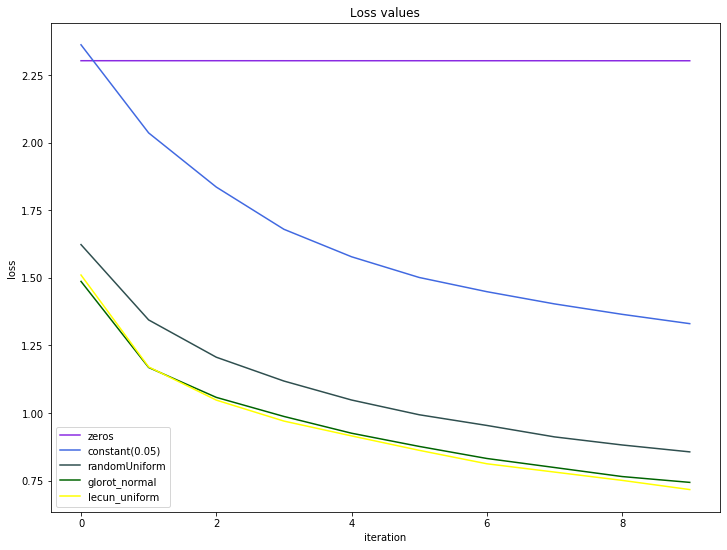

In [0]:
t = np.arange(0,10,1)
clr = ['blueviolet', 'royalblue', 'darkslategrey', 'darkgreen', 'yellow']
l = ['zeros', 'constant(0.05)', 'randomUniform', 'glorot_normal', 'lecun_uniform']

plt.figure(figsize = [12,9])
plt.xlabel('iteration')
plt.ylabel ('loss')
plt.title ('Loss values')
for i in range(len(inits)):
  plt.plot(t, losses[i], c=clr[i], label = l[i])

plt.legend(loc = 'lower left')

Из графика видно, что при весах, инициализированнных 0, значение loss не убывает. При весах = константе, сходимость функции потерь слишком медленная.
Лучшая сходимость - при весах, инициализированных с помощью lecun_uniform, потому что значение loss на последней итерации минимально + сходимость происходит быстрее (в сравнении с glorot_normal)

## Задание 2 — CNN для CIFAR-10 с сохранением весов модели (7 баллов)

В этом задании мы модифицируем нейросеть с семинара, чтобы она достигала большего значения `accuracy` и научимся сохранять веса модели в файл во время обучения. Можно использовать только те же слои, которые использовались на семинаре: `Conv2D, MaxPooling2D,  LeakyReLU, Dropout, Flatten, Dense`.

**Задание 2.1** (4 балла). Подберите архитектуру модели так, чтобы значение `accuracy` на тестовой выборке было не менее 85.

In [0]:
def my_model():    

    model = Sequential()
    
    model.add(Conv2D(filters=64, padding='same', kernel_size=(3,3), input_shape=(32,32,3), kernel_initializer = 'lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=128, padding='same', kernel_size=(3,3), kernel_initializer = 'lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 
    model.add(Dropout(0.25)) 
    
    model.add(Conv2D(filters=128, padding='same', kernel_size=(3,3), kernel_initializer = 'lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=256, padding='same', kernel_size=(3,3), kernel_initializer = 'lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 
    model.add(Dropout(0.25)) 

    model.add(Conv2D(filters=256, padding='same', kernel_size=(3,3), kernel_initializer = 'lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=512, padding='same', kernel_size=(3,3), kernel_initializer = 'lecun_uniform'))  
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 
    model.add(Dropout(0.25)) 
    
    model.add(Flatten())
    
    model.add(Dense(256, kernel_initializer = 'lecun_uniform'))                
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(10, kernel_initializer = 'lecun_uniform'))             
    model.add(Activation("softmax"))
    
    return model 

In [12]:
s = reset_tf_session()
model = my_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)      

**Задание 2.2** (2 балла). Реализуйте колбэк, который сохраняет модель в `.hdf5` файл и печатает имя файла, в который была сохранена модель. Используйте функцию `model_save`. Строка с именем файла имеет вид `<name>_{0:02d}.hdf5`, отформатируйте ее так, чтобы в имени строки фигурировал номер эпохи.

In [0]:
from keras.models import save_model, load_model

class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        file_name_epoch = self.file_name.split('_')[0] + '_epoch:' + str(epoch + 1) + '.hdf5'
        save_model(self.model, file_name_epoch)
        print (file_name_epoch)


**Задание 2.3** (1 балл). Реализуйте функцию, которая с помощью `load_model` будет загружать модель из файла.

In [0]:
def load_from_file(model_filename, last_epoch):
  file_name_epoch = model_filename.split('_')[0] + '_epoch:' + str(last_epoch+1) + '.hdf5'
  m = load_model(file_name_epoch)
  return m

In [9]:
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 20

model_filename = 'weights_{0:02d}.hdf5'

s = reset_tf_session()

model = my_model()

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adamax(lr=INIT_LR),
    metrics=['accuracy']
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch 

# в случае, если обучение было прервано, можно загрузить модель из файла, 
# соответствующего последней эпохе, за которую есть сохраненные веса
#model = load_from_file(model_filename, 4)
  
history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               # не забудьте передать сюда ModelSaveCallback
               ModelSaveCallback(model_filename)
              ],
    validation_data=(x_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0    
)
  







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 50000 samples, validate on 10000 samples
Epoch 1/20



50000/50000 [==============================] - 83s 2ms/step - loss: 1.4734 - acc: 0.4674 - val_loss: 0.9641 - val_acc: 0.6605
weights_epoch:1.hdf5
Epoch 2/20
50000/50000 [==============================] - 76s 2ms/step - loss: 0.9321 - acc: 0.6771 - val_loss: 0.7676 - val_acc: 0.7334
weights_epoch:2.hdf5
Epoch 3/20
50000/50000 [==============================] - 76s 2ms/step - loss: 0.7562 - acc: 0.7406 - val_loss: 0.6561 - val_acc: 0.7776
weights_epoch:3.hdf5
Epoch 4/20
50000/50000 [==============================] - 76s 2ms/step - loss: 0.6316 - acc: 0.7867 - val_loss: 0.6274 - val_acc: 0.7886
weights_epoch:4.hdf5
Epoch 5/20
50000/50000 [==============================] - 76s 2ms/step - loss: 0.5414 - acc: 0.

In [0]:
#model = load_from_file(model_filename, 10)

In [11]:
from sklearn.metrics import accuracy_score

res = np.argmax(y_test, axis = 1) #метки классов на тестовой выборке
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1) #метки классов на предсказаниях
print("Test accuracy:", accuracy_score(res, y_pred_test_classes))

Test accuracy: 0.8762


Таким образом, в результате построения архитектуры сети my_model, accuracy на тестовой выборке = 0.8762 (20 эпох, 32-batch size)